# Loading data For Training 
# Total Features : 12
# Target Feature : Disruption Types

In [ ]:
import pandas as pd
import numpy as np
class_path='C:\\Users\\HP\\OneDrive\\AppData\\Desktop\\!!74 pr\\src\\Flight_classification_data.csv'
df=pd.read_csv(class_path)

In [ ]:
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib 

In [ ]:
features = [
    'DayOfWeek',
    'DayofMonth',
    'Month',
    'Distance',
    'CRSDepMin',
    'CRSArrMin',
    'ScheduledElapsedTime',
    'OriginReliability',
    'DestReliability',
    'CarrierReliability',
    'DepTimeOfDay_enc',
    'ArrTimeOfDay_enc'
]

target = 'DisruptionType'
X = df[features]
y = df[target]

#  Encode Target

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Target mapping:")
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))



#  Train / Test Split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

Target mapping:
{'Cancelled': 0, 'Delayed': 1, 'Diverted': 2, 'On Time': 3}


In [12]:
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

# LightGBM Classifier for Multiclass classification over 4 labels
# Accuracy : 40%

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 799999, number of used features: 12
[LightGBM] [Info] Start training from score -1.386293
[LightGBM] [Info] Start training from score -1.386298
[LightGBM] [Info] Start training from score -1.386293
[LightGBM] [Info] Start training from score -1.386293

===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

   Cancelled       0.49      0.54      0.51     50000
     Delayed       0.42      0.35      0.38     50000
    Diverted       0.56      0.63      0.60     50000
     On Time       0.42      0.40      0.41     50000

    accuracy                           0.48    200000
   macro avg       0.47      0.48      0.48    200000
weighted avg       0.47      0.48      0.48    200000



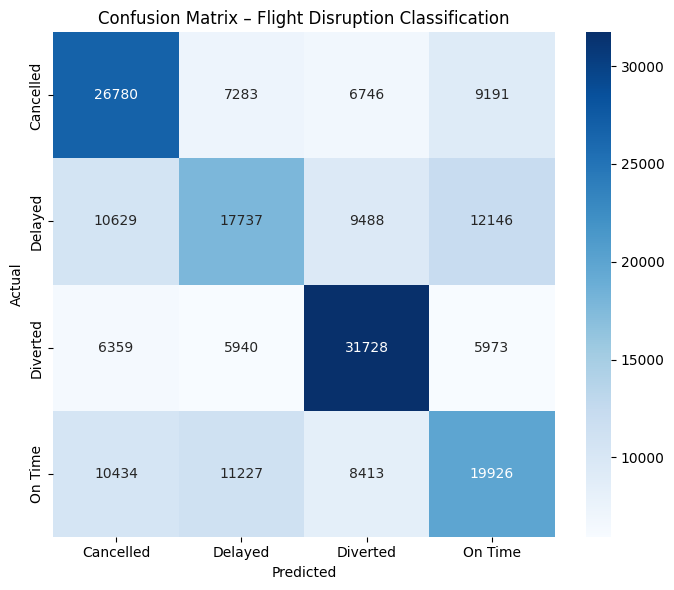

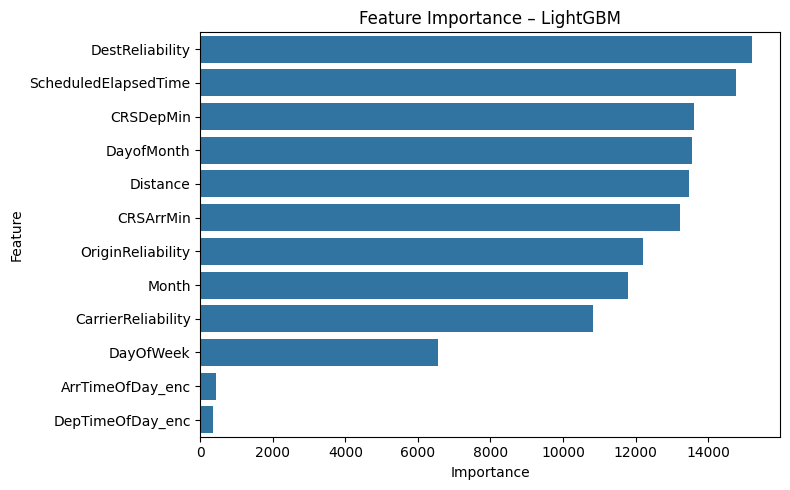

In [ ]:

model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss'
)



# Predictions

y_pred = model.predict(X_val)



# Classification Report

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(
    y_val,
    y_pred,
    target_names=label_encoder.classes_
))


#  Confusion Matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Flight Disruption Classification")
plt.tight_layout()
plt.show()



# Feature Importance (LightGBM)

importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importances, x='Importance', y='Feature')
plt.title("Feature Importance – LightGBM")
plt.tight_layout()
plt.show()

# XGBoost Classifier for Multiclass classification over 4 labels
# Accuracy : 50%

[0]	validation_0-mlogloss:1.38136
[50]	validation_0-mlogloss:1.27817
[100]	validation_0-mlogloss:1.24371
[150]	validation_0-mlogloss:1.22317
[200]	validation_0-mlogloss:1.20752
[250]	validation_0-mlogloss:1.19541
[300]	validation_0-mlogloss:1.18419
[350]	validation_0-mlogloss:1.17425
[400]	validation_0-mlogloss:1.16542
[450]	validation_0-mlogloss:1.15627
[499]	validation_0-mlogloss:1.14883

===== XGBOOST CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

   Cancelled       0.51      0.55      0.53     50000
     Delayed       0.43      0.37      0.40     50000
    Diverted       0.60      0.68      0.64     50000
     On Time       0.43      0.41      0.42     50000

    accuracy                           0.50    200000
   macro avg       0.49      0.50      0.50    200000
weighted avg       0.49      0.50      0.50    200000



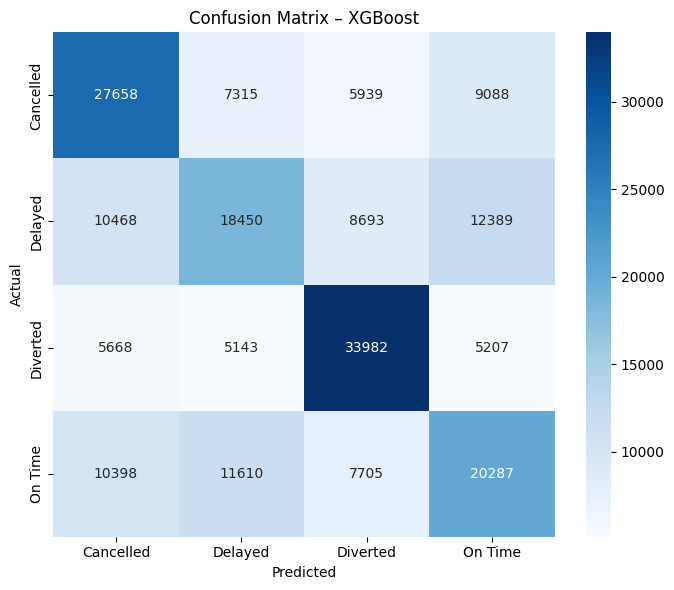

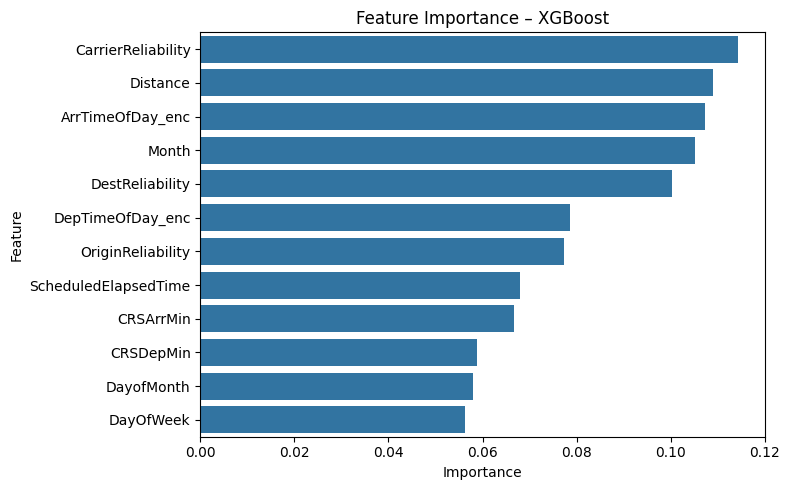

In [ ]:
import xgboost as xgb

# XGBoost Multiclass Model

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    tree_method='hist',     # fast + memory efficient
    random_state=42
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

# Predictions

y_pred = xgb_model.predict(X_val)



# Classification Report

print("\n===== XGBOOST CLASSIFICATION REPORT =====\n")
print(classification_report(
    y_val,
    y_pred,
    target_names=label_encoder.classes_
))



#  Confusion Matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost")
plt.tight_layout()
plt.show()



# Feature Importance

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance – XGBoost")
plt.tight_layout()
plt.show()

# CatBoost Classifier for Multiclass classification over 4 labels
# Accuracy : 43%

0:	learn: 1.3819363	test: 1.3819304	best: 1.3819304 (0)	total: 573ms	remaining: 4m 46s
100:	learn: 1.2941274	test: 1.2958576	best: 1.2958576 (100)	total: 40.4s	remaining: 2m 39s
200:	learn: 1.2733101	test: 1.2766128	best: 1.2766128 (200)	total: 1m 20s	remaining: 1m 59s
300:	learn: 1.2593335	test: 1.2642251	best: 1.2642251 (300)	total: 1m 59s	remaining: 1m 19s
400:	learn: 1.2467324	test: 1.2532279	best: 1.2532279 (400)	total: 2m 39s	remaining: 39.4s
499:	learn: 1.2357255	test: 1.2440054	best: 1.2440054 (499)	total: 3m 19s	remaining: 0us

bestTest = 1.244005352
bestIteration = 499


===== CATBOOST CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

   Cancelled       0.45      0.49      0.47     50000
     Delayed       0.39      0.33      0.36     50000
    Diverted       0.48      0.55      0.52     50000
     On Time       0.39      0.36      0.37     50000

    accuracy                           0.43    200000
   macro avg       0.43      0.43      0.4

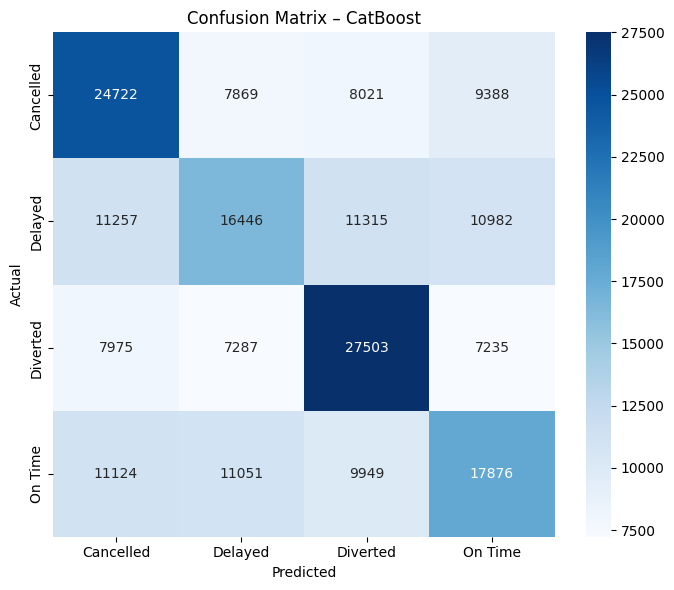

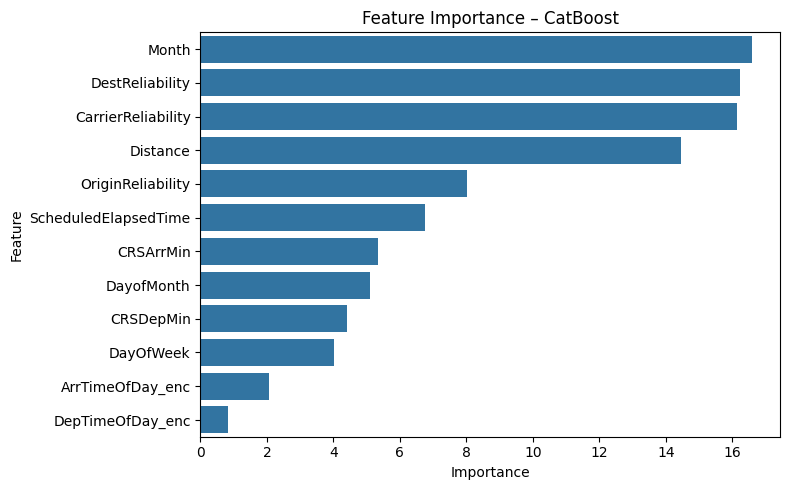

In [ ]:


from catboost import CatBoostClassifier


# CatBoost Multiclass Model

cat_model = CatBoostClassifier(
    loss_function='MultiClass',
    iterations=500,
    learning_rate=0.05,
    depth=8,
    eval_metric='MultiClass',
    random_seed=42,
    verbose=100
)

cat_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val)
)



# Predictions

y_pred = cat_model.predict(X_val).astype(int)



# Classification Report

print("\n===== CATBOOST CLASSIFICATION REPORT =====\n")
print(classification_report(
    y_val,
    y_pred,
    target_names=label_encoder.classes_
))



# Confusion Matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – CatBoost")
plt.tight_layout()
plt.show()

# Feature Importance

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': cat_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance – CatBoost")
plt.tight_layout()
plt.show()

# RandomForest Classifier for Multiclass classification over 4 labels
# Accuracy : 51%


===== RANDOM FOREST CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

   Cancelled       0.50      0.53      0.51     50000
     Delayed       0.43      0.37      0.40     50000
    Diverted       0.63      0.80      0.70     50000
     On Time       0.43      0.36      0.39     50000

    accuracy                           0.51    200000
   macro avg       0.50      0.51      0.50    200000
weighted avg       0.50      0.51      0.50    200000



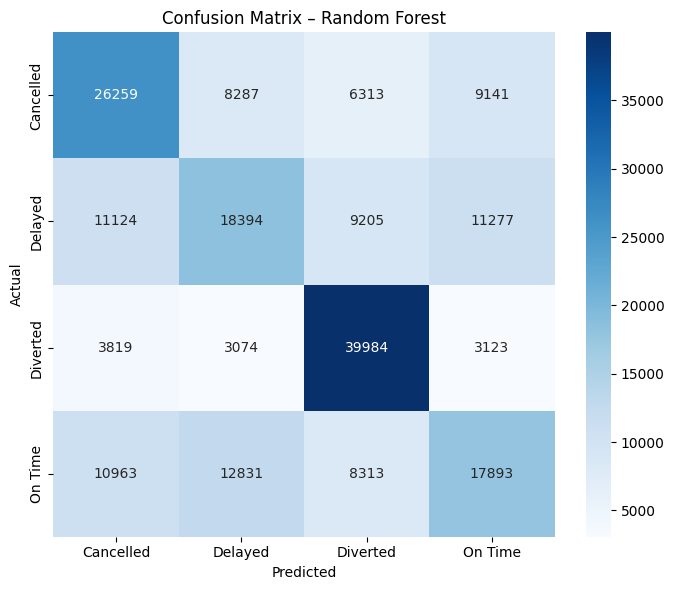

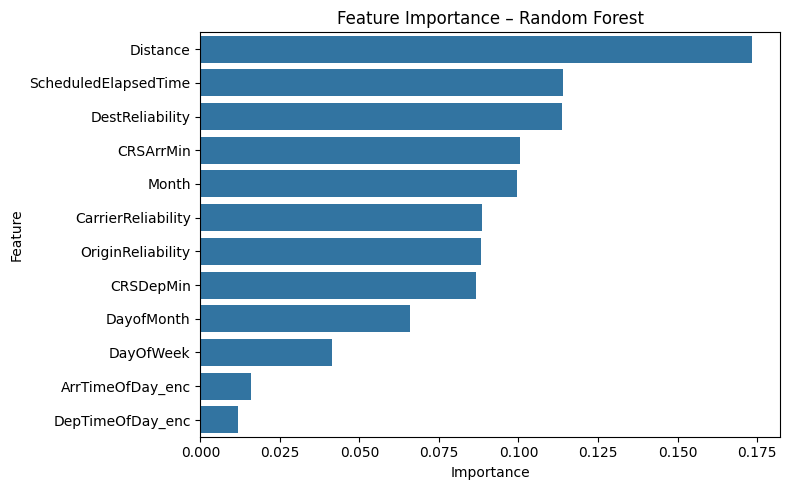

In [ ]:


from sklearn.ensemble import RandomForestClassifier


# Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,             
    min_samples_leaf=50,         
    class_weight='balanced',      
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)


# Predictions

y_pred = rf_model.predict(X_val)



# Classification Report

print("\n===== RANDOM FOREST CLASSIFICATION REPORT =====\n")
print(classification_report(
    y_val,
    y_pred,
    target_names=label_encoder.classes_
))



# Confusion Matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()

# Feature Importance

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance – Random Forest")
plt.tight_layout()
plt.show()

# All 4 classifiers have lower accuracy 
# Moving on to hierachial 4 stage classifiers 
# DIVERTED VS OTHERS 
# ON TIME VS DELAYED 
# DELAYED VS CANCELLED 
# DELAYED VS CANCELLED 


ON TIME VS DELAYED , ACCURACY : 60%

In [28]:
df_ot_del = df[df['DisruptionType'].isin(['On Time', 'Delayed'])].copy()

df_ot_del['y'] = df_ot_del['DisruptionType'].map({
    'On Time': 0,
    'Delayed': 1
})

X_ot_del = df_ot_del[features]
y = df_ot_del['y']

X_train_ot_del, X_test, y_train, y_test = train_test_split(
    X_ot_del, y, test_size=0.2, stratify=y, random_state=42
)

clf_ot_del = RandomForestClassifier(
    n_estimators=300,
    max_depth=18,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

clf_ot_del.fit(X_train_ot_del, y_train)

y_pred = clf_ot_del.predict(X_test)

print("===== On Time vs Delayed =====")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

===== On Time vs Delayed =====
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     50000
           1       0.59      0.62      0.61     50000

    accuracy                           0.60    100000
   macro avg       0.60      0.60      0.60    100000
weighted avg       0.60      0.60      0.60    100000

[[28642 21358]
 [18899 31101]]


DELAYED VS CANCELLED , ACCURACY : 74%

In [29]:
df_del_can = df[df['DisruptionType'].isin(['Delayed', 'Cancelled'])].copy()

df_del_can['y'] = df_del_can['DisruptionType'].map({
    'Delayed': 0,
    'Cancelled': 1
})

X_del_can = df_del_can[features]
y = df_del_can['y']

X_train_del_can, X_test, y_train, y_test = train_test_split(
    X_del_can, y, test_size=0.2, stratify=y, random_state=42
)

clf_del_can = RandomForestClassifier(
    n_estimators=300,
    max_depth=18,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

clf_del_can.fit(X_train_del_can, y_train)

y_pred = clf_del_can.predict(X_test)

print("===== Delayed vs Cancelled =====")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

===== Delayed vs Cancelled =====
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     50000
           1       0.73      0.77      0.75     50000

    accuracy                           0.74    100000
   macro avg       0.74      0.74      0.74    100000
weighted avg       0.74      0.74      0.74    100000

[[35870 14130]
 [11600 38400]]


ON TIME VS CANCELLED , ACCURACY: 74%

In [30]:
df_ot_can = df[df['DisruptionType'].isin(['On Time', 'Cancelled'])].copy()

df_ot_can['y'] = df_ot_can['DisruptionType'].map({
    'On Time': 0,
    'Cancelled': 1
})

X_ot_can= df_ot_can[features]
y = df_ot_can['y']

X_train_ot_can, X_test, y_train, y_test = train_test_split(
    X_ot_can, y, test_size=0.2, stratify=y, random_state=42
)

clf_ot_can = RandomForestClassifier(
    n_estimators=300,
    max_depth=18,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

clf_ot_can.fit(X_train_ot_can, y_train)
y_pred = clf_ot_can.predict(X_test)
print("===== On Time vs Cancelled =====")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

===== On Time vs Cancelled =====
              precision    recall  f1-score   support

           0       0.74      0.73      0.74     50000
           1       0.73      0.74      0.74     50000

    accuracy                           0.74    100000
   macro avg       0.74      0.74      0.74    100000
weighted avg       0.74      0.74      0.74    100000

[[36618 13382]
 [12979 37021]]


DIVERTED VS OTHERS , ACCURACY: 86%

In [31]:
df_div = df.copy()

df_div['y'] = (df_div['DisruptionType'] == 'Diverted').astype(int)

X_div = df_div[features]
y = df_div['y']

X_train_div, X_test, y_train, y_test = train_test_split(
    X_div, y, test_size=0.2, stratify=y, random_state=42
)

clf_div = RandomForestClassifier(
    n_estimators=300,
    max_depth=16,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

clf_div.fit(X_train_div, y_train)

y_pred = clf_div.predict(X_test)

print("===== Diverted vs Others =====")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

===== Diverted vs Others =====
              precision    recall  f1-score   support

           0       0.95      0.87      0.91    150000
           1       0.68      0.86      0.76     50000

    accuracy                           0.86    200000
   macro avg       0.81      0.86      0.83    200000
weighted avg       0.88      0.86      0.87    200000

[[130031  19969]
 [  7155  42845]]


# SAVING ALL THE 4 MODELS

In [ ]:
import joblib

joblib.dump(clf_div, "clf_diverted.pkl")
joblib.dump(clf_ot_del, "clf_ot_delayed.pkl")
joblib.dump(clf_del_can, "clf_del_cancelled.pkl")
joblib.dump(clf_ot_can, "clf_ot_cancelled.pkl")

# Hard voting over the binary classifiers 
# Classifies over all 4 labels 
# Hard voting logic :
# 1. If Diverted model says YES → Diverted
# 2. Else:
#      a. Check OnTime vs Delayed
#        - If On Time:
#               i. Check OnTime vs Cancelled
#                   → On Time or Cancelled
#         - If Delayed:
#               i. Check Delayed vs Cancelled
#                   → Delayed or Cancelled

# Accuracy : 70%


===== HARD-VOTING CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

   Cancelled       0.73      0.73      0.73     12559
     Delayed       0.71      0.61      0.66     12694
    Diverted       0.70      0.87      0.78     12339
     On Time       0.69      0.62      0.65     12408

    accuracy                           0.71     50000
   macro avg       0.71      0.71      0.70     50000
weighted avg       0.71      0.71      0.70     50000

Accuracy: 0.7076


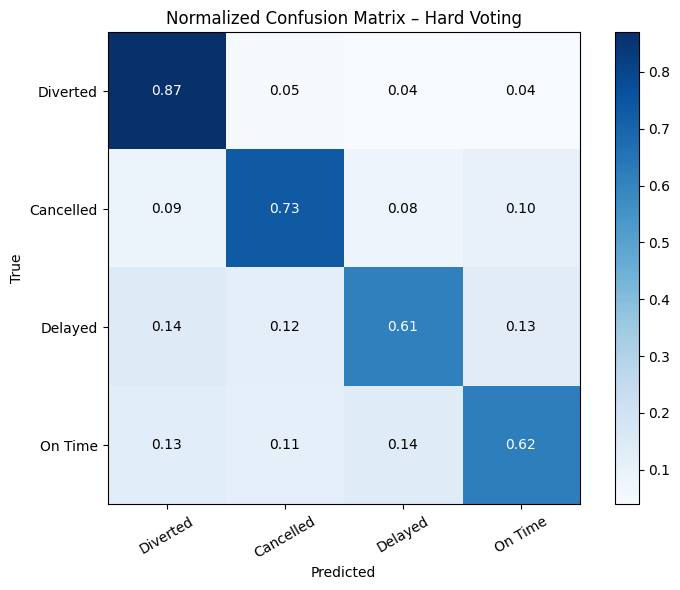

In [ ]:

# IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)


# FAST HARD-VOTING INFERENCE FUNCTION

def infer_diverted_then_vote(
    df, features,
    clf_div,
    clf_ot_del,
    clf_del_can,
    clf_ot_can
):
    X = df[features]

    # ---- Stage 1: Diverted gate ----
    is_diverted = clf_div.predict(X) == 1

    # ---- Stage 2: Hard labels from other models ----
    ot_del = clf_ot_del.predict(X)      # 1 = Delayed, 0 = On Time
    del_can = clf_del_can.predict(X)    # 1 = Cancelled, 0 = Delayed
    ot_can = clf_ot_can.predict(X)      # 1 = Cancelled, 0 = On Time

    n = len(df)

    # ---- Vote counters ----
    votes_cancelled = np.zeros(n, dtype=int)
    votes_delayed = np.zeros(n, dtype=int)
    votes_ontime = np.zeros(n, dtype=int)

    # OnTime vs Delayed
    votes_delayed += (ot_del == 1)
    votes_ontime += (ot_del == 0)

    # Delayed vs Cancelled
    votes_cancelled += (del_can == 1)
    votes_delayed += (del_can == 0)

    # OnTime vs Cancelled
    votes_cancelled += (ot_can == 1)
    votes_ontime += (ot_can == 0)

    # ---- Pick class with max votes ----
    vote_matrix = np.vstack([
        votes_cancelled,
        votes_delayed,
        votes_ontime
    ]).T

    other_labels = np.array(["Cancelled", "Delayed", "On Time"])
    other_preds = other_labels[np.argmax(vote_matrix, axis=1)]

    # ---- Final prediction ----
    final_preds = np.where(is_diverted, "Diverted", other_preds)

    return final_preds

#  SAMPLE DATA FOR EVALUATION

df_eval = df.sample(50000, random_state=42).copy()


X_eval = df_eval[features]


#  RUN INFERENCE

df_eval["Predicted"] = infer_diverted_then_vote(
    df_eval,
    features,
    clf_div,
    clf_ot_del,
    clf_del_can,
    clf_ot_can
)


#  METRICS

print("\n===== HARD-VOTING CLASSIFICATION REPORT =====\n")
print(classification_report(
    df_eval["DisruptionType"],
    df_eval["Predicted"]
))

print("Accuracy:",
      round(
          accuracy_score(
              df_eval["DisruptionType"],
              df_eval["Predicted"]
          ),
          4
      )
)


# CONFUSION MATRIX 

LABELS = ["Diverted", "Cancelled", "Delayed", "On Time"]

cm = confusion_matrix(
    df_eval["DisruptionType"],
    df_eval["Predicted"],
    labels=LABELS
)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, cmap="Blues")
plt.colorbar()

plt.xticks(range(len(LABELS)), LABELS, rotation=30)
plt.yticks(range(len(LABELS)), LABELS)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix – Hard Voting")

for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black"
        )

plt.tight_layout()
plt.show()

# Two stage classifiers 

# Stage 1: Getting probabilities from the binary classifiers from each model 

# Segregating probabilities for each individual label from the model probabilities using formulas = CLASS-LEVEL PROBABILITY DECOMPOSITION (CORE LOGIC)


# Stage 2 : Building Extra Tree classifier over the segregated probabilities

# Accuracy :
# Train accuracy = 72%
# Test accuracy = 74%

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


#  FEATURES USED BY BASE MODELS


features = [
    'DayOfWeek',
    'DayofMonth',
    'Month',
    'Distance',
    'CRSDepMin',
    'CRSArrMin',
    'ScheduledElapsedTime',
    'OriginReliability',
    'DestReliability',
    'CarrierReliability',
    'DepTimeOfDay_enc',
    'ArrTimeOfDay_enc'
]

X = df[features]
y = df['DisruptionType']


# ENCODE TARGET

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Target mapping:")
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


# TRAIN / HOLDOUT SPLIT


X_base, X_meta, y_base, y_meta = train_test_split(
    X,
    y_encoded,
    test_size=0.30,
    random_state=42,
    stratify=y_encoded
)

Target mapping:
{'Cancelled': 0, 'Delayed': 1, 'Diverted': 2, 'On Time': 3}


In [ ]:
# training data preparation

p_div = clf_div.predict_proba(X_meta)[:, 1]
p_del = clf_ot_del.predict_proba(X_meta)[:, 1]
p_can_del = clf_del_can.predict_proba(X_meta)[:, 1]
p_can_ot = clf_ot_can.predict_proba(X_meta)[:, 1]


# CLASS-LEVEL PROBABILITY DECOMPOSITION (CORE LOGIC)

P_diverted = p_div

P_cancelled = (p_can_del * p_del) + (p_can_ot * (1 - p_del))

P_delayed = p_del * (1 - p_can_del)

P_ontime = (1 - p_del) * (1 - p_can_ot)



#  META FEATURE MATRIX


X_meta_final = pd.DataFrame({
    'P_Diverted': P_diverted,
    'P_Cancelled': P_cancelled,
    'P_Delayed': P_delayed,
    'P_OnTime': P_ontime
})

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

meta_et = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=20,      # important for stability
    max_features=2,           # force diversity
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

meta_et.fit(X_meta_final, y_meta)


y_pred = meta_et.predict(X_meta_final)

print("\n===== EXTRA TREES META CLASSIFIER (Training Data) =====\n")

print(classification_report(
    y_meta,
    y_pred,
    target_names=label_encoder.classes_
))

print("Train Accuracy:", round(accuracy_score(y_meta, y_pred), 4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_meta, y_pred))


===== EXTRA TREES META CLASSIFIER (Training Data) =====

              precision    recall  f1-score   support

   Cancelled       0.74      0.78      0.76     75000
     Delayed       0.67      0.63      0.65     75000
    Diverted       0.79      0.85      0.82     75000
     On Time       0.69      0.65      0.67     75000

    accuracy                           0.73    300000
   macro avg       0.72      0.73      0.72    300000
weighted avg       0.72      0.73      0.72    300000

Train Accuracy: 0.7252

Confusion Matrix:
[[58127  6465  4774  5634]
 [ 7970 47351  6574 13105]
 [ 4136  4114 63443  3307]
 [ 7994 12718  5650 48638]]


In [37]:
# test data preparation

p_div_test = clf_div.predict_proba(X_base)[:, 1]
p_del_test = clf_ot_del.predict_proba(X_base)[:, 1]
p_can_del_test = clf_del_can.predict_proba(X_base)[:, 1]
p_can_ot_test = clf_ot_can.predict_proba(X_base)[:, 1]

X_test= pd.DataFrame({
    "P_Diverted": p_div_test,
    "P_Cancelled": (p_can_del_test * p_del_test) + (p_can_ot_test * (1 - p_del_test)),
    "P_Delayed": p_del_test * (1 - p_can_del_test),
    "P_OnTime": (1 - p_del_test) * (1 - p_can_ot_test)
})

In [38]:
y_pred_test = meta_et.predict(X_test)

print("\n===== EXTRA TREES META CLASSIFIER (Test Data) =====\n")

print(classification_report(
    y_base,
    y_pred_test,
    target_names=label_encoder.classes_
))

print("Test Accuracy:", round(accuracy_score(y_base, y_pred_test), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_base, y_pred_test))


===== EXTRA TREES META CLASSIFIER (Test Data) =====

              precision    recall  f1-score   support

   Cancelled       0.74      0.77      0.75    175000
     Delayed       0.69      0.73      0.71    174999
    Diverted       0.78      0.84      0.81    175000
     On Time       0.74      0.63      0.68    175000

    accuracy                           0.74    699999
   macro avg       0.74      0.74      0.74    699999
weighted avg       0.74      0.74      0.74    699999

Test Accuracy: 0.7409

Confusion Matrix:
[[133926  15409  11729  13936]
 [ 17272 127314  14603  15810]
 [ 10151   9924 146676   8249]
 [ 19310  31000  13999 110691]]


In [39]:
joblib.dump(meta_et, 'meta_extratrees.pkl')

['meta_extratrees.pkl']